# Timing Notebook

In [3]:
# Import the usual libraries
%pylab
%matplotlib inline
import pandas as pd
import os
plt.style.use('PUBstyle')
# Import sarkas
from sarkas.processes import Simulation, PostProcess, PreProcess
from sarkas.tools.transport import TransportCoefficient
from scipy.optimize import curve_fit


# Create the file path to the YAML input file
example_directory = os.path.join('..',
                                 os.path.join('sarkas',
                                              os.path.join('examples', 'Timing')))

input_file_names = [
    'ocp_N10k.yaml',
    'ocp_N20k.yaml',
    'ocp_N50k.yaml',
    'ocp_N100k.yaml',
    'ocp_N200k.yaml',
    'ocp_N500k.yaml',
    'ocp_N1000k.yaml',
] 

ptcls_num = np.array([10000, 20000, 50000, 100000, 200000, 500000, 1000000])
mean_pp_times = np.zeros(len(input_file_names) )
mean_pm_times = np.zeros(len(input_file_names) )
std_pp_times = np.zeros(len(input_file_names) )
std_pm_times = np.zeros(len(input_file_names) )



Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [4]:
# for i, fname in enumerate(input_file_names):
#     inp = os.path.join(example_directory, fname)

#     preproc = PreProcess(inp)
#     preproc.setup(read_yaml=True)
#     preproc.run(
# #          timing=False, # time estimation, default is True
# #          loops = 10,   # the number of timesteps to average, Default is 10
#          pppm_estimate=True,
# #         timing_study = True,
# #         postprocessing=True,
#         remove = True, # Save some space.
#                )
# #     print("{}".format(preproc.parameters.box_lengths[0]/preproc.potential.rc) )
#     ptcls_num[i] = preproc.parameters.total_num_ptcls
#     mean_pp_times[i] = np.mean(preproc.pp_acc_time[1:])
#     std_pp_times[i] = np.std(preproc.pp_acc_time[1:])
#     mean_pm_times[i] = np.mean(preproc.pm_acc_time[1:])
#     std_pm_times[i] = np.std(preproc.pm_acc_time[1:])
    
#     print('Mean PP Times: {:.6e}'.format(mean_pp_times[i]) )
#     print('Mean PM Times: {:.6e}'.format(mean_pm_times[i]) )
#     print(fname, ' Done')

In [5]:
# data = pd.DataFrame( 
#     np.stack( (ptcls_num, mean_pp_times, std_pp_times, mean_pm_times ,std_pm_times) , axis = 1),
#     columns = ['Particles',
#                'Numba Mean PP Times', 
#                'Numba Std PP Times',
#                'Numba Mean PM Times',
#                'Numba Std PM Times'] )
# data.to_csv('Numba_timing.csv', index = False)

In [6]:
data = pd.read_csv('Timing_Data.csv', index_col=False)

In [7]:
data


,Particles,Numba Mean Times,Numba Std Times,Python Mean Times,Python Std Times,C Mean Times,C Std Times
0,10000.0,1.607255e+08,5.156055e+06,5.260791e+10,1.630793e+08,2.653379e+08,2.131156e+06
1,20000.0,2.975319e+08,3.370340e+06,7.673028e+10,2.773674e+08,5.049276e+08,3.742605e+06
2,50000.0,8.639297e+08,2.229352e+07,2.315224e+11,3.924550e+08,1.325084e+09,3.268709e+06
3,100000.0,1.853293e+09,3.205940e+07,4.717860e+11,1.460930e+09,2.797184e+09,8.918109e+06
4,200000.0,3.297458e+09,3.479448e+07,7.714762e+11,2.921848e+09,5.500079e+09,5.608437e+07
5,500000.0,8.445286e+09,5.592634e+07,2.068121e+12,5.795861e+09,1.435861e+10,3.753178e+08


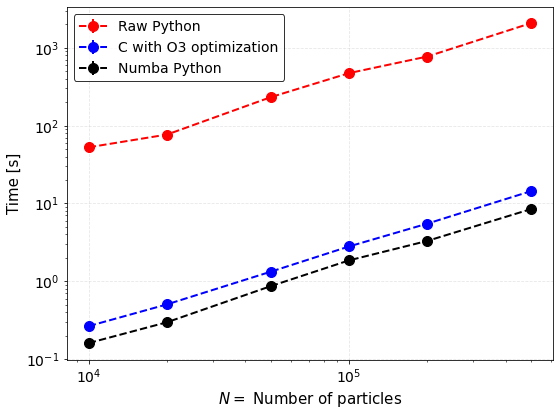

In [8]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.errorbar(ptcls_num[:-1], 
               data['Python Mean Times']*1e-9, 
               yerr = data['Python Std Times']*1e-9, fmt = '--ro', ms = 10, label = 'Raw Python')
ax.errorbar(ptcls_num[:-1], data["C Mean Times"]*1e-9, 
               yerr = data["C Std Times"]*1e-9, fmt = '--bo', ms = 10, label = 'C with O3 optimization')
ax.errorbar(ptcls_num[:-1], data["Numba Mean Times"]*1e-9, 
               yerr = data["Numba Std Times"]*1e-9, fmt = '--ok', ms = 10, label = 'Numba Python')

ax.set(yscale = 'log', 
       xscale='log', 
       ylabel = r'Time [s]', 
       xlabel = r'$N = $ Number of particles')
ax.legend()
# ax.set_xticks([1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
# ax.set_xticklabels([r'$10^4$', r'$2 \times 10^4$', r'$5\times 10^4$', r'$10^5$', r'$2 \times 10^5$', r'$5\times 10^5$'])
# ax[1].legend()
fig.tight_layout()
fig.savefig('Timing.pdf')

In [12]:
c_speedup = abs(data["C Mean Times"]/data["Numba Mean Times"])
py_speedup = abs(data["Python Mean Times"]/data["Numba Mean Times"])

In [13]:
py_speedup

0    327.315396
1    257.889198
2    267.987521
3    254.566367
4    233.960854
5    244.884664
dtype: float64

In [14]:
c_speedup

0    1.650876
1    1.697054
2    1.533787
3    1.509305
4    1.667975
5    1.700192
dtype: float64